# VOYAGER DATA

Aiming to reproduce a particularly messy structure function in FraternaleEA (2019):

- Have pretty much reproduced the structure functions from the inner heliosheath (V1, 2011), at least at a reduced frequency due to computation time
- In order to be able to apply the correction factor, I need a standardised interval. This will be a subsection of the full SF of that figure
- I also need the LINT version

But I might also want to do it for the LISM, which has even higher % missing data. This regime only has power spectra rather than SFs in this paper, but this is fine, as we can compute equivalent spectra and compare it then. However, I will not be able to quickly reproduce Frat's spectra as they use their suite of spectra estimation methods, so I will need to scrape the data.


In [4]:
import numpy as np
import pandas as pd
import cdflib
import math as m
import pprint

# import seaborn as sns
import importlib
from scipy import signal
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import gridspec
import matplotlib.dates as mdates

# while ".toplevel" not in os.listdir():
#     os.chdir("..")

from src.data_import_funcs import read_cdfs, date_1d_dict, read_asc_ts
import src.utils as utils

# Set matplotlib font size
plt.rc("text", usetex=True)
plt.rc("font", family="serif", serif="Computer Modern", size=20)


## CDF metadata

In [5]:
cdf_file = cdflib.CDF("data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf")

In [6]:
pprint.pprint(cdf_file.globalattsget(expand=False))

{'ADID_ref': 'NSSD0110',
 'Acknowledgement': ' Please acknowledge the Principal Investigator, Norman F. '
                    'Ness of the Bartol Research Institute, University of '
                    'Delaware, and the NASA National Space Science Data Center '
                    '(NSSDC) for usage of data from this site in publications '
                    'and presentations.',
 'Data_type': '48SEC>48 second Time Resolution',
 'Data_version': '1',
 'Descriptor': 'VIM>Magnetic Field VIM',
 'Discipline': ['Space Physics>Interplanetary Studies',
                'Solar Physics>Heliospheric Physics'],
 'HTTP_LINK': 'http://cohoweb.gsfc.nasa.gov',
 'Instrument_type': 'Magnetic Fields (space)',
 'LINK_TEXT': 'Voyager1 merged magnetic field and plasma hourly data from ',
 'LINK_TITLE': 'COHOWeb Service',
 'Logical_file_id': 'voyager1_48s_mag-vim_v01',
 'Logical_source': 'voyager1_48s_mag-vim',
 'Logical_source_description': 'Voyager1 Magnetic field VIM',
 'MODS': ' ',
 'Mission_group': ['V

In [7]:
# Full data structure
pprint.pprint(cdf_file.cdf_info())

{'Attributes': [{'TITLE': 'Global'},
                {'Project': 'Global'},
                {'Discipline': 'Global'},
                {'Source_name': 'Global'},
                {'Data_type': 'Global'},
                {'Descriptor': 'Global'},
                {'Data_version': 'Global'},
                {'Generated_by': 'Global'},
                {'Generation_date': 'Global'},
                {'TEXT': 'Global'},
                {'MODS': 'Global'},
                {'ADID_ref': 'Global'},
                {'Logical_file_id': 'Global'},
                {'Logical_source': 'Global'},
                {'Logical_source_description': 'Global'},
                {'PI_name': 'Global'},
                {'PI_affiliation': 'Global'},
                {'Mission_group': 'Global'},
                {'Instrument_type': 'Global'},
                {'Time_resolution': 'Global'},
                {'Web_site': 'Global'},
                {'Acknowledgement': 'Global'},
                {'Rules_of_use': 'Global'},
   

In [8]:
# Variable names - zVariables are variables that can have dimensionalities that are different than those of the rVariables (and each other).
pprint.pprint(cdf_file.cdf_info()["zVariables"])

['Epoch',
 'Epoch_ephem',
 'spacecraftID',
 'F1',
 'BR',
 'BT',
 'BN',
 'dF',
 'dBR',
 'dBT',
 'dBN',
 'Radius',
 'hg_lat',
 'hg_lon',
 'hgi_lon']


In [9]:
pprint.pprint(cdf_file.varattsget("F1"))  # variable attributes

{'CATDESC': 'B Field Magnitude (average of fine scale magnitudes)',
 'DEPEND_0': 'Epoch',
 'DISPLAY_TYPE': 'time_series',
 'FIELDNAM': 'B Field Magnitude',
 'FILLVAL': -1e+31,
 'FORMAT': 'f10.5',
 'LABLAXIS': 'Voyager1_BField',
 'UNITS': 'nT',
 'VALIDMAX': 10.0,
 'VALIDMIN': -10.0,
 'VAR_TYPE': 'data'}


In [10]:
pprint.pprint(cdf_file.varattsget("Epoch"))  # variable attributes

{'AVG_TYPE': ' ',
 'CATDESC': 'Time, beginning of interval',
 'DICT_KEY': 'time>epoch',
 'DISPLAY_TYPE': ' ',
 'FIELDNAM': 'Time',
 'FILLVAL': -1e+31,
 'FORMAT': 'E14.8',
 'LABLAXIS': 'Epoch',
 'MONOTON': 'INCREASE',
 'SCALEMAX': 63745056000000.0,
 'SCALEMIN': 62987673600000.0,
 'SCALETYP': 'LINEAR',
 'UNITS': 'ms',
 'VALIDMAX': 63745056000000.0,
 'VALIDMIN': 62987673600000.0,
 'VAR_NOTES': ' ',
 'VAR_TYPE': 'support_data'}


In [11]:
print(
    "Missing values for this variable are replaced with:",
    cdf_file.varattsget("BR")["FILLVAL"],
)

BR = cdf_file.varget("BR")

print("The structure of this variable is", format(type(BR)))
print("The type of data stored in this variable is", format(BR.dtype))

print(BR)

Missing values for this variable are replaced with: -1e+31
The structure of this variable is <class 'numpy.ndarray'>
The type of data stored in this variable is float32
[ 0.06866  0.06511  0.0655  ... -0.01047 -0.01163 -0.01678]


# Fraternale et al. (2019)

Using adapted function from Tulasi to read in multiple CDFs at once into a dictionary

In [12]:
voyager1_data_raw = read_cdfs(
    [
        # "data/raw/voyager/voyager1_48s_mag-vim_20090101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20100101_v01.cdf",
        "data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20120101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20130101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20140101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20150101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20160101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20170101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20180101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20190101_v01.cdf",
    ],
    ["Epoch", "F1", "BR", "BT", "BN"],
)

reading file  data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf
Done reading data


Converting dictionary into dated dataframe

In [13]:
voyager1_data = date_1d_dict(
    voyager1_data_raw, "48S"
)  # Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off
# voyager2_data = date_1d_dict(voyager2_data_raw, "48S")
# voyager1_data['mag_calculated'] = (voyager1_data['BR']**2 + voyager1_data['BT']**2 + voyager1_data['BN']**2)**(1/2)
# voyager1_data[voyager1_data.mag_calculated < 0.03] = np.nan
# print(voyager1_data.mag_calculated.min())
len(voyager1_data)
# len(voyager2_data)

Here is a snippet of the raw data (before re-sampling according to freq)
                              F1       BR       BT       BN
Time                                                       
2011-01-01 12:37:31.584  0.21758  0.06866  0.15611  0.13507
2011-01-01 12:38:19.968  0.22162  0.06511  0.15956  0.13923
2011-01-01 12:39:08.352  0.21891  0.06550  0.15134  0.14371
2011-01-01 12:39:55.872  0.21616  0.06289  0.15407  0.13775
2011-01-01 12:40:44.255  0.21758  0.06584  0.15295  0.14001


654641

In [14]:
def convert_angle(x):
    if x < 0:
        x += 360
    return x


voyager1_data["lambda"] = (
    voyager1_data["BT"]
    .div(voyager1_data["BR"])
    .apply(m.atan)
    .apply(m.degrees)
    .apply(convert_angle)
)
voyager1_data["delta"] = (
    voyager1_data["BN"].div(voyager1_data["F1"]).apply(m.asin).apply(m.degrees)
)

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

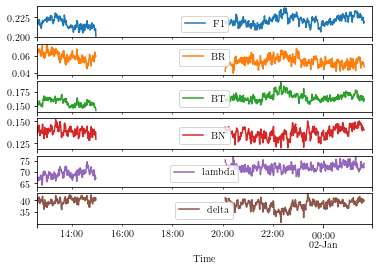

In [15]:
voyager1_data[:1000].plot(subplots=True)

In [16]:
# Proportion of missing data
print(voyager1_data.isna().sum() / len(voyager1_data["F1"]))

F1        0.694581
BR        0.694581
BT        0.694581
BN        0.694581
lambda    0.694581
delta     0.694581
dtype: float64


Re-creating Fraternale 2019 Fig. 1(a)

In [17]:
# Resample to daily cadence
voyager1_data_daily = voyager1_data.resample("D").mean()

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>], dtype=object)

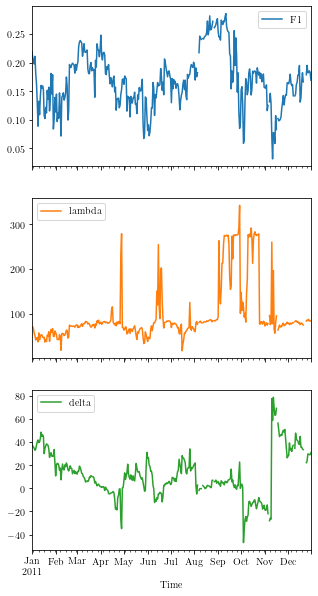

In [18]:
voyager1_data_daily[["F1", "lambda", "delta"]].plot(subplots=True, figsize=(5, 10))

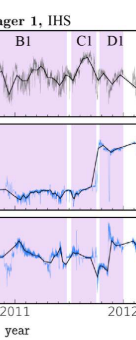

Looks fine, apart from lambda.

Proceeding to extract interval D1 (we won't be using lambda)

In [19]:
# Get DOY 276-365 from the raw data
subset = voyager1_data["2011-10-03":"2011-12-31"]
del voyager1_data
del voyager1_data_daily
print(len(subset))

160587


In [20]:
subset.isna().sum() / len(subset)

F1        0.798315
BR        0.798315
BT        0.798315
BN        0.798315
lambda    0.798315
delta     0.798315
dtype: float64

80% data missing

### Reproducing full SFs

In [21]:
subset_resampled = subset.resample("10min").mean()  # Now only 12,000 long
len(subset_resampled)

12847

In [22]:
# Takes about 30 seconds

sf = utils.calc_struct_sdk(
    data=subset_resampled["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)


In [23]:
subset_lint = subset_resampled.interpolate(method="linear")

sf_lint = utils.calc_struct_sdk(
    data=subset_lint["BT"],
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)

Implementing Frat's statistical sigificance threshold

In [24]:
# Define the window size for 48 hours in seconds
# Convert index to time index
sf.index = pd.to_timedelta(sf.index, unit="s")

window_size = pd.to_timedelta("48H")

# Compute the rolling maximum for a 48-hour window
sf["rolling_max"] = (
    sf["N"].rolling(window=window_size, min_periods=1, center=True).max()
)

# Compute the threshold
sf["threshold"] = 0.25 * sf["rolling_max"]

# Determine the color based on the threshold
sf["color"] = np.where(sf["N"] < sf["threshold"], "gray", "black")

# Convert the time index to back to seconds
sf.index = sf.index.total_seconds()


### Computing standard SF

Calculating correlation time, using full 60-day dataset

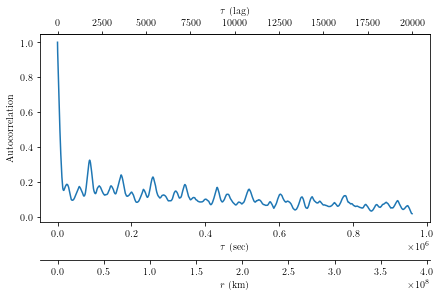

Correlation time = 8694.0s = 2.0 hours


In [25]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [subset.BR, subset.BT, subset.BN],
    nlags=20000,
    plot=True,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)
print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")


Note highly wiggly ACF due to gaps. Also calculating $\lambda_C$ using integral method

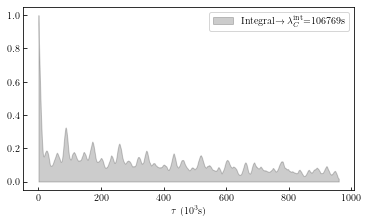

29.658154039051336
hours


In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
tc, fig, ax = utils.compute_outer_scale_integral(time_lags_lr, r_vec_lr, fig, ax, True)
# print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")

plt.show()
print(tc / 60 / 60)
print("hours")

In [27]:
print(
    "10 of these is ",
    10 * tc / 60 / 60,
    "days, compared with full data length of",
    subset.index[-1] - subset.index[0],
)

10 of these is  296.5815403905134 days, compared with full data length of 89 days 05:08:48


This version is much longer (which will make things easier for standardising the interval - but is it accurate?)

In [28]:
tc_n = 10
interval_length = 10000
new_cadence = tc_n * tc / interval_length

In [29]:
subset_std = subset.resample(str(np.round(new_cadence)) + "S").mean()
int_std = subset_std[:10000]

<Axes: xlabel='Time'>

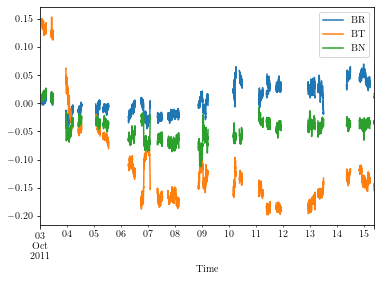

In [30]:
int_std[["BR", "BT", "BN"]].plot()

In [31]:
print(int_std.isna().sum() / len(int_std["BR"]))

F1        0.6598
BR        0.6598
BT        0.6598
BN        0.6598
lambda    0.6598
delta     0.6598
dtype: float64


In [38]:
sf_std = utils.calc_struct_sdk(
    data=int_std["BT"],
    freq=1 / new_cadence,
    orders=[2],
    max_lag_fraction=0.2,
    plot=False,
)

int_std_lint = int_std.interpolate(method="linear")

sf_std_lint = utils.calc_struct_sdk(
    data=int_std_lint["BT"],
    freq=1 / new_cadence,
    orders=[2],
    max_lag_fraction=0.2,
    plot=False,
)

In [33]:
del subset, subset_lint

Text(24000.0, 5e-08, '12h')

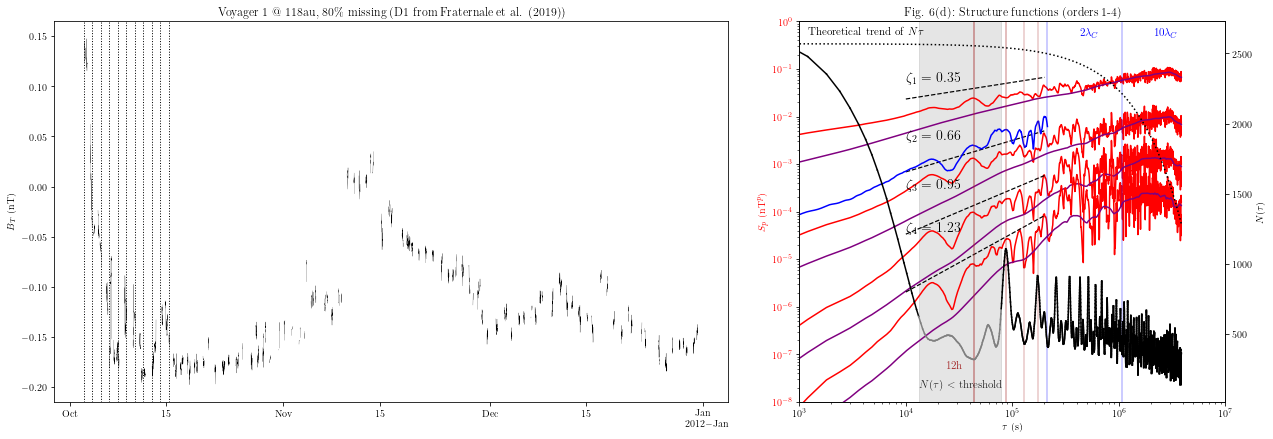

In [39]:
# Plot structure functions
xlim = (1e3, 1e7)
ylim_sf = (1e-8, 1e0)
ylim_kurt = (2, 10)

# sdk = sf[[2, 4]].copy()
# sdk["kurtosis"] = sdk[4].div(sdk[2] ** 2)


fig = plt.figure(figsize=(21, 7))
gs = gridspec.GridSpec(1, 5, wspace=0.4)
ax0 = plt.subplot(gs[0, 0:3])

ax1 = plt.subplot(gs[0, 3:])

ax0.plot(subset_resampled.BT, c="black", lw=0.2)
for i in range(11):
    ax0.axvline(
        subset_resampled.index[0] + pd.Timedelta(tc * i, "s"),
        color="black",
        linestyle="dotted",
        lw=1,
    )
ax0.set_title(r"Voyager 1 @ 118au, 80\% missing (D1 from Fraternale et al. (2019))")
ax0.set_ylabel("$B_T$ (nT)")
ax0.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax0.xaxis.get_major_locator())
)

for p in [1, 2, 3, 4]:
    ax1.plot(sf.index, sf[p], c="red", label=f"p={p}")
    qi, xi, pi = utils.fitpowerlaw(sf.index, sf[p].values, 1e4, 2e5)
    ax1.plot(
        xi,
        pi * 2,
        c="black",
        ls="--",
        lw=1.2,
        label="Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(qi[0]),
    )

    # Add the slope value as an annotation based on location of the fit
    plt.annotate(
        "$\\zeta_{0} = {1:.2f}$".format(p, qi[0]),
        (xi[0], np.median(pi) * 2),
        fontsize=14,
    )

    ax1.plot(sf_lint.index, sf_lint[p], c="purple", label=f"p={p}")

ax1.plot(sf_std.index, sf_std[2], c="blue", label="10 lambda C")
ax1.semilogx()
ax1.semilogy()
ax1.set(title="Fig. 6(d): Structure functions (orders 1-4)", xlabel="Lag (s)")
if xlim is not None:
    ax1.set_xlim(xlim)
if ylim_sf is not None:
    ax1.set_ylim(ylim_sf)

# plt.show()

ax1.set_xlabel("$\\tau$ (s)")
ax1.set_ylabel("$S_p$ (nT$^p$)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

rectangle_x = sf[sf.color == "gray"].index[0]
rectangle_width = sf[sf.color == "gray"].index[-1] - sf[sf.color == "gray"].index[0]

# Add rectangle to show the range of the power-law fit
ax1.add_patch(
    plt.Rectangle(
        (rectangle_x, 1e-8),
        rectangle_width,
        1,
        color="black",
        alpha=0.1,
    ),
)

ax2 = ax1.twinx()
plt.plot(
    sf.index,
    0.2 * (len(subset_resampled) - (sf.index / 600)),
    color="black",
    ls="dotted",
    label="Theoretical sample size",
)
for i in range(len(sf) - 1):
    ax2.plot(
        sf.index[i : i + 2],
        sf["N"].values[i : i + 2],
        color=sf["color"].values[i],
    )
ax2.set_ylabel("$N(\\tau)$", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax1.text(rectangle_x, 2e-8, "$N(\\tau)<$ threshold", fontsize=11, alpha=0.8)
ax1.text(1.2e3, 5e-1, "Theoretical trend of $N\\tau$", fontsize=11)
# Add vertical line at lag equal to 8 correlation times
ax1.axvline(x=10 * tc, c="blue", lw=2, alpha=0.2)
ax1.axvline(x=2 * tc, c="blue", lw=2, alpha=0.2)
# ax1.axvline(x=48 * 3600, c="purple", lw=2, alpha=0.2)
ax1.axvline(x=12 * 3600, c="brown", lw=2, alpha=0.4)
ax1.axvline(x=24 * 3600, c="brown", lw=2, alpha=0.3)
ax1.axvline(x=36 * 3600, c="brown", lw=2, alpha=0.2)
ax1.axvline(x=48 * 3600, c="brown", lw=2, alpha=0.2)

ax1.text(10 * tc * 1.5, 5e-1, "$10\\lambda_C$", fontsize=11, c="blue")
ax1.text(2 * tc * 1.5, 5e-1, "$2\\lambda_C$", fontsize=11, c="blue")

# ax1.text(48 * 3600 * 1.2, 5e-1, "Burger max lag", fontsize=11, c="purple")
ax1.text(12 * 3600 / 1.8, 5e-8, "12h", fontsize=11, c="brown")

# plt.savefig("plots/background/voyager_sf.png")


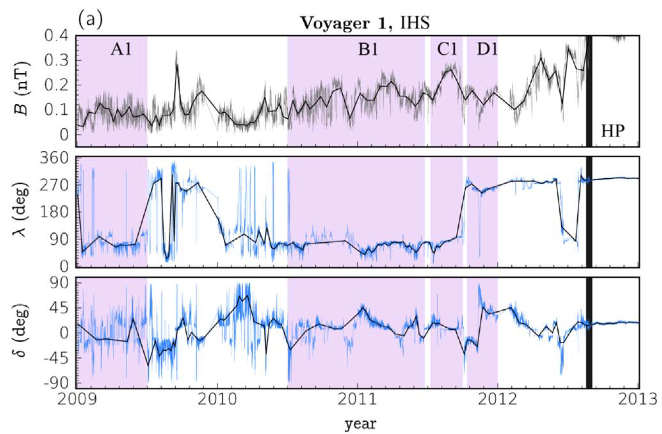  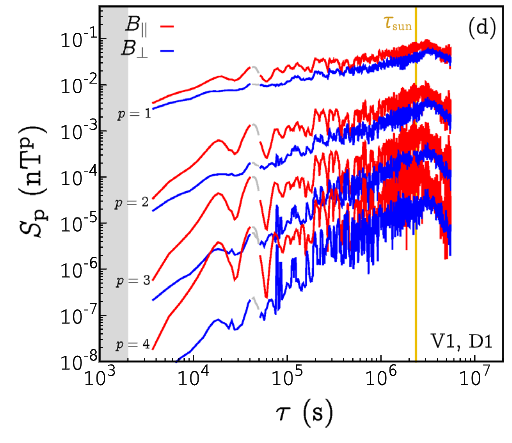 



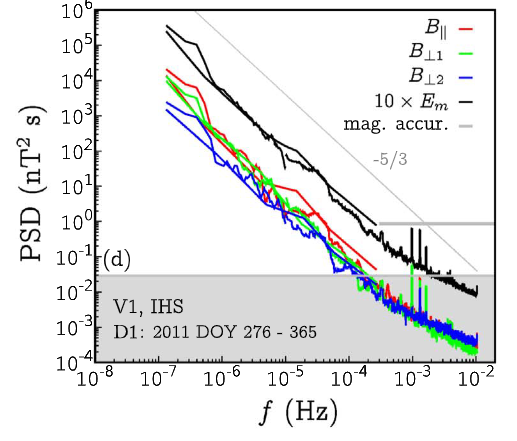



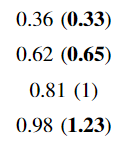

**Thresholding procedure**
"the computation of $S$ is nontrivial for Voyager data sets due to the amount and distribution of missing data." They do not interpolate, but they do account for the variable reduction in sample size at each lag by applying a threshold of statistical significance as to whether they use certain lags to calculate the slopes

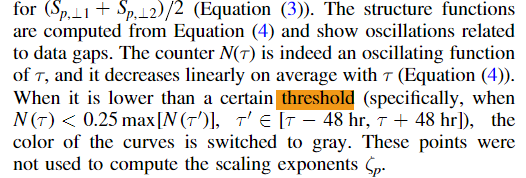

Interestingly, the slopes $\zeta_p$ from my re-sample are closer to the theoretical ESS values!

Focussing on second-order SF ($p=2$). Let's standardise the interval according to my procedure, wanting 8 corr lengths.

Dominant gap periodicity found to be 43,000s = 12h (typicaly daily telemetry gap of 8-16hr: lines up with major trough in $N(\tau)$): minima occur at multiples of this frequency

A spectral break was not identified in the (corrected) spectra for this interval, but elsewhere it was found to be at about 1-2e-5

- Increase # corr lengths used in standardisation
- Decrease interval length
- Settle with interval size that won't allow us to directly compare with these results

[]

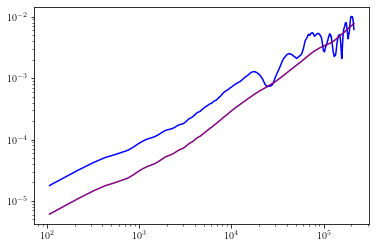

In [40]:
import matplotlib.pyplot as plt

plt.plot(sf_std.index, sf_std[2], c="blue")
plt.plot(sf_std_lint.index, sf_std_lint[2], c="purple")
plt.semilogx()
plt.semilogy()

In [42]:
sf_std["N_theoretical"] = len(int_std) - (sf_std.index.values / 48)
sf_std["missing_prop"] = sf_std["N"] / sf_std["N_theoretical"]

sf_std["classical"] = sf_std[2]
sf_std = sf_std.reset_index()
sf_std["Lag"] = sf_std["index"]

sf_std.head()

index         2       N  N_theoretical  missing_prop  classical  \
0  106.769355  0.000018  3364.0    9997.775638      0.336475   0.000018   
1  213.538709  0.000031  3346.0    9995.551277      0.334749   0.000031   
2  320.308064  0.000042  3328.0    9993.326915      0.333022   0.000042   
3  427.077418  0.000051  3304.0    9991.102554      0.330694   0.000051   
4  533.846773  0.000056  3282.0    9988.878192      0.328565   0.000056   

          Lag  
0  106.769355  
1  213.538709  
2  320.308064  
3  427.077418  
4  533.846773

See Fig. 5(d) below for the power spectrum and metadata. Note that this power spectra was built using the technique they developed of compressed sensing, as well as linear interpolation + BT-method for $f<10^{-5}$


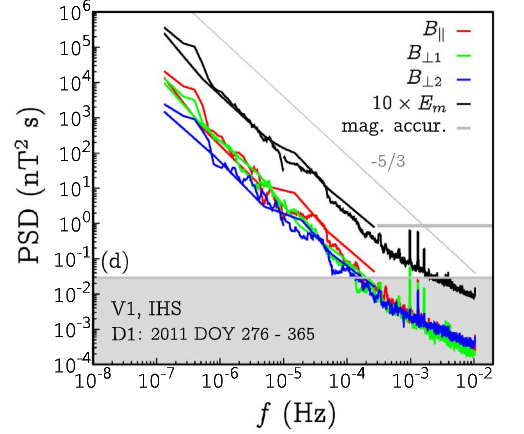

The correlation length is about 2 hours. I have been standardising my intervals to have 8 correlation lengths: they have 800. 8 correlation lengths only just gets us to the start of the range over which they perform they power-law fit. We would need about 20 to cover that full range.

Correlation timescale is about 2 and half hours. An interval of 3500 and 20 timescales would match the resolution: larger interval or fewer timescales would not work, would have to increase or decrease both.

---

# Burlaga et al. (2014)

[Paper](http://dx.doi.org/10.1088/0004-637X/792/2/134)

In [150]:
# IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
# Get longest non-missing period, investigate properties (not needed when averaging data)
# a = voyager1_data["F1"].values  # Extract out relevant column from dataframe as array
# m = np.concatenate(([True], np.isnan(a), [True]))  # Mask
# ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1, 2)  # Start-stop limits
# start, stop = ss[(ss[:, 1] - ss[:, 0]).argmax()]  # Get max interval, interval limits
# print(voyager1_data["F1"][[start]])
# print(voyager1_data["F1"][[stop - 1]])



In [151]:
# # Proportion of missing data
# print(voyager2_data["F1"].isna().sum() / len(voyager2_data["F1"]))

# # IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
# # Get longest non-missing period, investigate properties (not needed when averaging data)
# a = voyager2_data["F1"].values  # Extract out relevant column from dataframe as array
# m = np.concatenate(([True], np.isnan(a), [True]))  # Mask
# ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1, 2)  # Start-stop limits
# start, stop = ss[(ss[:, 1] - ss[:, 0]).argmax()]  # Get max interval, interval limits
# print(voyager2_data["F1"][[start]])
# print(voyager2_data["F1"][[stop - 1]])

In [152]:
# clean = voyager2_data["2017-07-29 20:56:48":"2017-07-30 16:08:00"]
# len(clean)
# # clean.head()

In [153]:
# voyager1_data[20000:30000].to_csv("data/processed/voyager1_48s.csv")

In [154]:
# Reproducing Burlaga et al. (2014) Fig. 1
burlaga_subset = voyager1_data["2011":"2013-06"].resample("D").mean()
burlaga_subset["abs(BT)"] = burlaga_subset["BT"].apply(abs)
burlaga_subset[["abs(BT)", "F1"]].plot()
plt.show()

NameError: name 'voyager1_data' is not defined

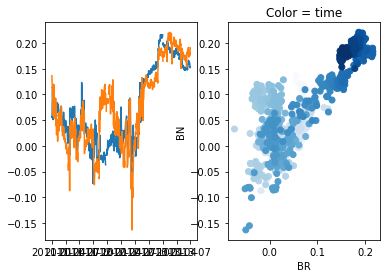

In [ ]:
# See how correlation between the two components changes with time
fig, axs = plt.subplots(1, 2)
axs[0].plot(burlaga_subset[["BR", "BN"]])
axs[1].scatter(
    burlaga_subset["BR"],
    burlaga_subset["BN"],
    c=burlaga_subset.index,
    cmap=plt.cm.Blues,
)
axs[1].set(xlabel="BR", ylabel="BN", title="Color = time")
plt.show()

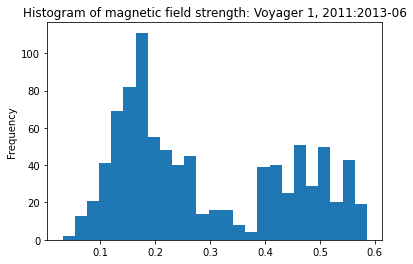

In [ ]:
# Reproducing Burlaga et al. (2014) Fig. 2
burlaga_subset["F1"].plot(
    kind="hist",
    bins=25,
    title="Histogram of magnetic field strength: Voyager 1, 2011:2013-06",
)
# Clear bimodal distribution represents Heliosheath (smaller values) and Interstellar magnetic field (larger values)
plt.show()

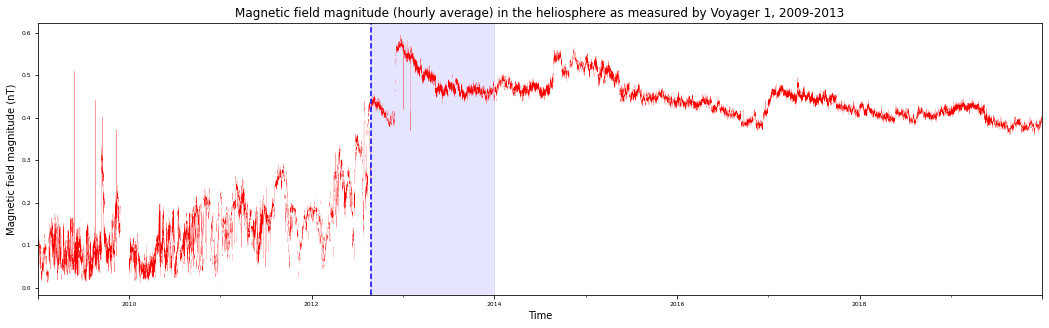

In [ ]:
# Raw data for B with line for heliopause (takes a long time to run)
temp_plot = (
    voyager1_data["F1"]
    .resample("H")
    .mean()
    .plot(
        color="red",
        figsize=(18, 5),
        lw=0.2,
        fontsize=6,
        title="Magnetic field magnitude (hourly average) in the heliosphere as measured by Voyager 1, 2009-2013",
    )
)
temp_plot.set_ylabel("Magnetic field magnitude (nT)")
# Adding a vertical line (e.g. to emphasise a heliospheric boundary)
temp_plot.axvline("2012-08-25", color="blue", linestyle="--")
# Adding a shaded region (e.g. to highlight a heliospheric region)
temp_plot.axvspan("2012-08-25", "2013-12-31", color="blue", alpha=0.1)

## Removing outliers

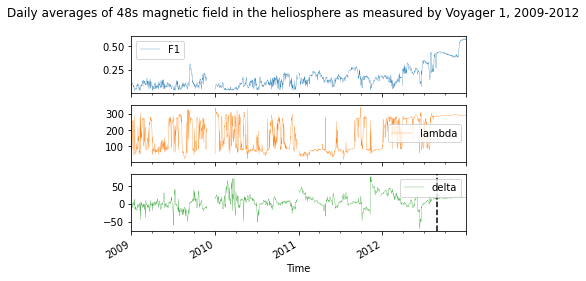

In [ ]:
# Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data1 = (
    voyager1_data[["F1", "lambda", "delta"]]["2009":"2012"].resample("D").mean()
)
smoothed_data1.plot(
    subplots=True,
    title="Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 1, 2009-2012",
    lw=0.3,
)
plt.axvline("2012-08-25", color="black", linestyle="--")
plt.show()

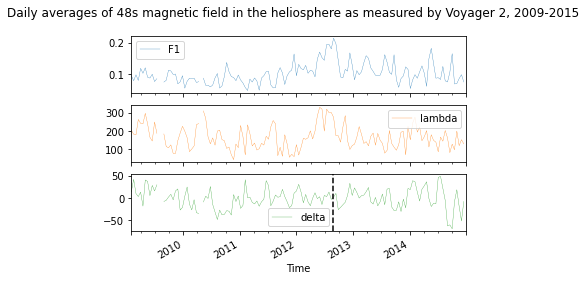

In [ ]:
# Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data2 = (
    voyager2_data[["F1", "lambda", "delta"]]["2009":"2014"].resample("15D").mean()
)
smoothed_data2.plot(
    subplots=True,
    title="Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 2, 2009-2015",
    lw=0.3,
)
plt.axvline("2012-08-25", color="black", linestyle="--")
plt.show()

In [ ]:
SHS1_V2 = voyager2_data["2009-07-01":"2009-07-3"]
print(SHS1_V2)  # Some missing data

clean_short = voyager1_data["2009-05-10 12:38":"2009-05-10 23:59"]["F1"].dropna()
print(clean_short)

                          F1       BT       BR       BN      lambda      delta
Time                                                                          
2009-07-01 00:00:00      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:00:48      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:01:36      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:02:24      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:03:12      NaN      NaN      NaN      NaN         NaN        NaN
...                      ...      ...      ...      ...         ...        ...
2009-07-03 23:56:00  0.07554 -0.05825  0.04721 -0.00332  309.023803  -2.518974
2009-07-03 23:56:48  0.06801 -0.05055  0.04212 -0.01717  309.802226 -14.623301
2009-07-03 23:57:36  0.06757 -0.04179  0.04965 -0.01630  319.912953 -13.959225
2009-07-03 23:58:24  0.06124 -0.03953  0.03767 -0.01169  313.619825 -11.004630
2009-07-03 23:59:12  0.07379 -0.05490  0.04436 -0.02

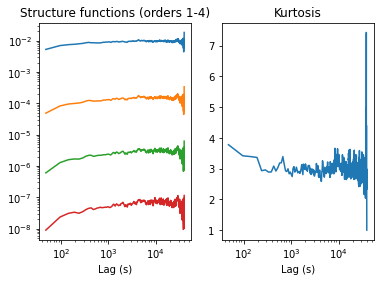

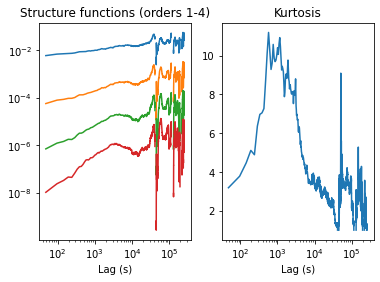

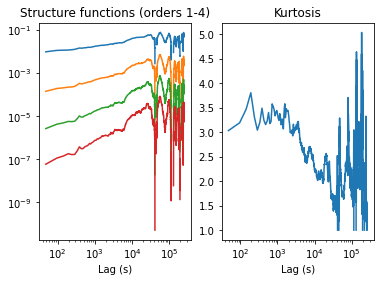

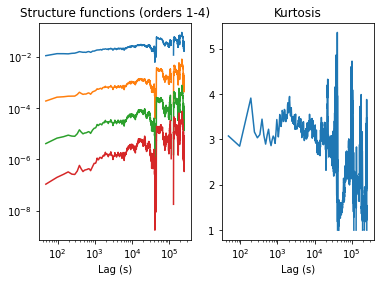

In [ ]:
calc_struct_sdk(clean_short, 1 / 48)  # Period of 12 hours (no missing data)
calc_struct_sdk(SHS1_V2["BR"], 1 / 48)  # Period of three days, including missing data
calc_struct_sdk(SHS1_V2["BT"], 1 / 48)  # Period of three days, including missing data
calc_struct_sdk(SHS1_V2["BN"], 1 / 48)  # Period of three days, including missing data

## Comparing with Tulasi's function

In [ ]:
# Tulasi's kurtosis function


def kurtosis(series, ptlag):
    """
    Routine to perform the Kurtosis on a series at a certain lag
    Input:
        series: the series to take the kurtosis of
        ptlag: the array of lags that represents the number of points to shift the series by
    Output:
        k: the kurtosis of the series
        ptlag: same array as input
    """
    k = []
    ptlag = np.asarray(ptlag).astype(int)
    series = series.copy()
    for i in ptlag:
        temp = (series.shift(-i) - series).copy()
        if (temp.pow(2).mean()) ** 2 == 0 or (temp.pow(4).mean()) == 0:
            coeff = np.NaN
        else:
            coeff = temp.pow(4).mean() / (temp.pow(2).mean() ** 2)
        k += [coeff]
    k = pd.Series(k)

    return k, ptlag

[]

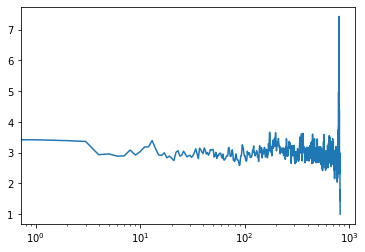

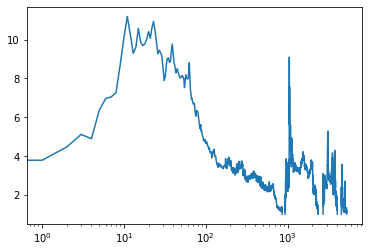

In [ ]:
lags_1 = np.arange(1, len(clean_short))
lags_2 = np.arange(1, len(SHS1_V2))

kurtosis_output, array = kurtosis(clean_short, lags_1)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

kurtosis_output, array = kurtosis(SHS1_V2["BR"], lags_2)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

## Testing on simulated data

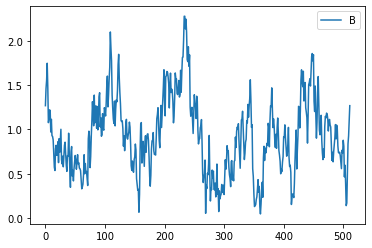

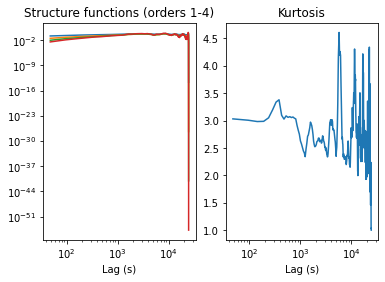

[]

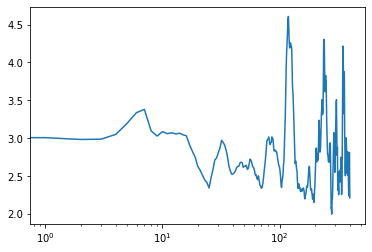

In [ ]:
df = pd.read_csv("Bmag_sim")
df.head()
df.plot()
calc_struct_sdk(df["B"], 1 / 48)

lags = np.arange(1, 400)
kurtosis_output, array = kurtosis(df["B"], lags)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

Looking at data gaps and performing v simple interpolation

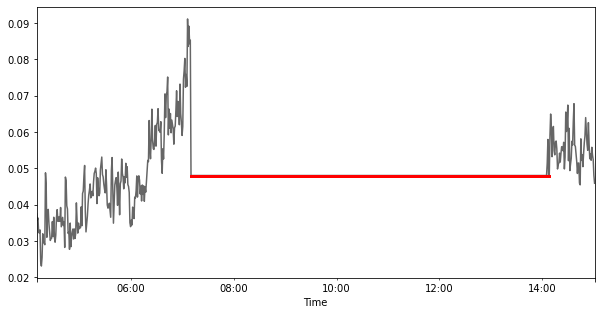

In [ ]:
subset = voyager1_data["F1"]["2009-01-01 04:00":"2009-01-01 15:00"]
missing_values = subset.isna()
# vygr_interp = subset.interpolate('zero')
# Could also replace with median of dataset
vygr_interp = subset.fillna(np.nanmedian(subset))
fig, ax = plt.subplots(figsize=(10, 5))
vygr_interp.plot(color="k", alpha=0.6, ax=ax, legend=False)
vygr_interp[missing_values].plot(ax=ax, color="r", lw=3, legend=False)
plt.show()

## Spectral analysis

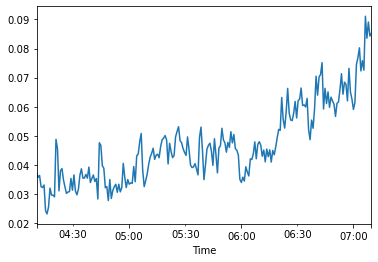

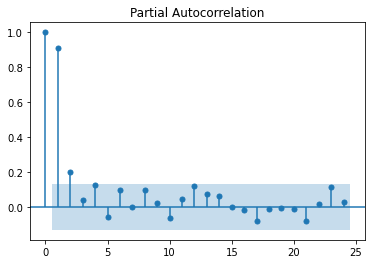

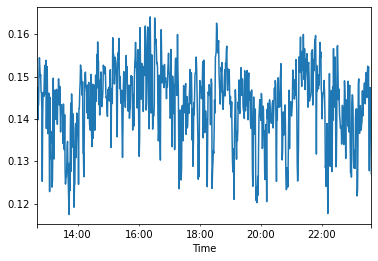

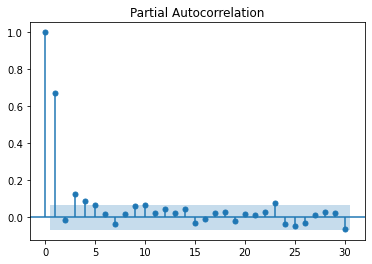

In [ ]:
# Extracting a couple of clean subsets and calculating (partial) autocorrelation

subset = voyager1_data["F1"]["2009-01-01 4:10:24":"2009-01-01 07:09"]
subset.isnull().sum()
subset.plot()
plt.show()

tsaplots.plot_pacf(subset)
plt.show()

subset2 = voyager1_data["2009-05-10 12:38":"2009-05-10 23:59"]["F1"].dropna()
subset2.plot()

tsaplots.plot_pacf(subset2)
plt.show()

In [ ]:
k = np.arange(1, 251) / 10000  # wavenumber for each mode
alpha = -5 / 3  # power law for power spectrum

A_1 = (k ** (-5 / 3)) / 1000000  # amplitudes
A_2 = (k ** (-5 / 6)) / 1000  # amplitudes

plt.plot(k, A)
plt.semilogx()
plt.semilogy()
plt.show()

NameError: name 'A' is not defined

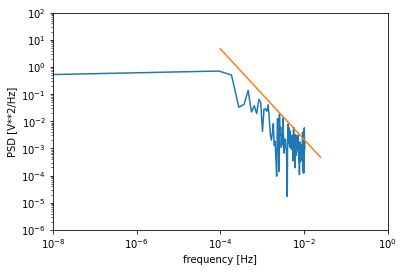

In [ ]:
# Calculating power density spectrum (I think)
# 1/48s = 0.0208Hz is the maximum frequency

f, Pxx_den = signal.periodogram(subset, 0.0208)  # See also: signal.welch
plt.semilogy(f, Pxx_den)
plt.plot(k, A_1)
plt.semilogx()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.show()

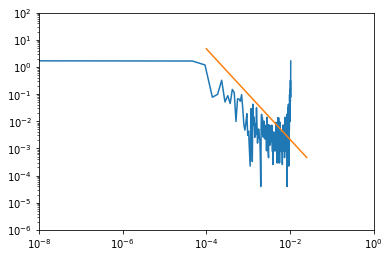

In [ ]:
# Power spectrum (here) = square of absolute value of discrete Fourier transform
sampling_rate = 1 / 48

fourier_transform = np.fft.fft(subset)  # Compute Fourier transform of data
magnitudes = abs(fourier_transform)
power_spectrum = np.square(magnitudes)

frequency = np.linspace(0, sampling_rate / 2, len(power_spectrum))

plt.plot(frequency, power_spectrum)
plt.plot(k, A_1)
plt.semilogx()
plt.semilogy()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.show()

# Proton temp and density


In [ ]:
data = read_asc_ts(
    "voyager/voyager1_daily.asc",
    [0, 1, 2, 14, 15],
    {
        "Year": 999.999,
        "Day": 999.999,
        "Hour": 999.999,
        "Proton density": 99.99999,
        "Proton temperature": 9999999,
    },
    "D",
)

The unique hours in this dataset are: [0]


In [ ]:
data.head()

Proton density  Proton temperature
Time                                          
1977-01-01             NaN                 NaN
1977-01-02             NaN                 NaN
1977-01-03             NaN                 NaN
1977-01-04             NaN                 NaN
1977-01-05             NaN                 NaN

In [ ]:
print(data[data["Proton density"].notnull()])
print(data[data["Proton temperature"].notnull()])

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...                 ...
1980-11-21         0.13605             14242.0
1980-11-22         0.22841             11759.0
1980-12-22         0.00254              4168.0
1980-12-30         0.00334             27008.0
1980-12-31         0.00440             58516.0

[1116 rows x 2 columns]
            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...         

<AxesSubplot:xlabel='Time'>

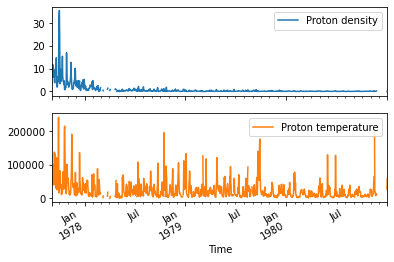

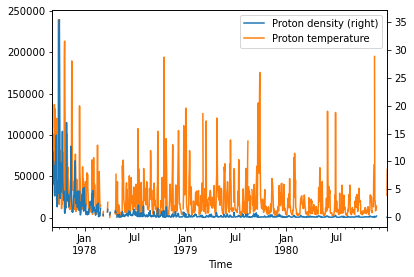

In [ ]:
# Revising the range of the data
data = data["1977-09-07":"1980-12-31"]
data.plot(subplots=True)
data.plot(secondary_y="Proton density")

In [ ]:
data.isnull().sum().div(len(data))  # % missing data

Proton density        0.079208
Proton temperature    0.079208
dtype: float64

In [ ]:
data.describe()

Proton density  Proton temperature
count     1116.000000         1116.000000
mean         0.842078        24275.247312
std          2.501148        27757.026962
min          0.002080          410.000000
25%          0.066733         7687.250000
50%          0.158105        15233.500000
75%          0.462703        30067.250000
max         35.379840       239761.000000

In [ ]:
raw_corr = data["Proton density"].corr(data["Proton temperature"])
pct_chg_corr = (
    data["Proton density"].pct_change().corr(data["Proton temperature"].pct_change())
)
print("Correlation of proton density and proton temperature %4.2f" % (raw_corr))
print(
    "Correlation of proton density and proton temperature percent changes %4.2f"
    % (pct_chg_corr)
)

Correlation of proton density and proton temperature 0.22
Correlation of proton density and proton temperature percent changes 0.32


<AxesSubplot:ylabel='Density'>

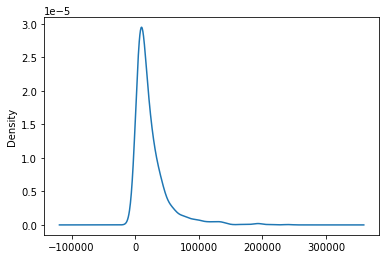

In [ ]:
data["Proton temperature"].plot(kind="density")

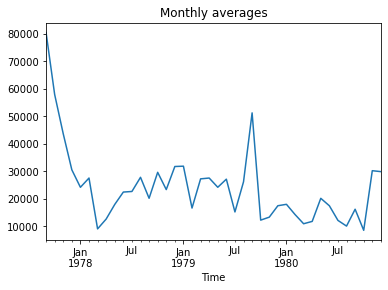

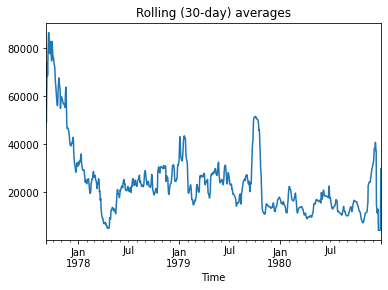

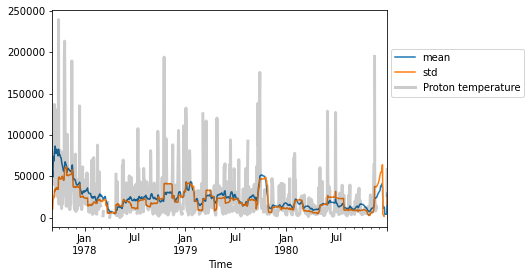

In [ ]:
temp = data["Proton temperature"]

monthly = temp.resample("M").mean()
monthly.plot(title="Monthly averages")
plt.show()
monthly = temp.rolling(window="30D").mean()
monthly.plot(title="Rolling (30-day) averages")

rolling_stats = temp.rolling(window="30D").agg(["mean", "std"])
# stats = temp.join(rolling_stats)
# stats[['Proton temperature', 'max', 'std']].plot(subplots = True, title = 'Daily voyager temp with rolling (30-day) mean and standard deviation')

ax = rolling_stats.plot()
temp.plot(ax=ax, color="k", alpha=0.2, lw=3)
ax.legend(loc=(1.01, 0.6))
plt.show()

## Calculating lag

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
            Proton density  Proton temperature
Time                                          
1977-09-08         5.26076            -14904.0
1977-09-09        -3.70966             38026.0
1977-09-10        -1.87010             12692.0
1977-09-11         2.49386              8507.0
1977-09-12        -2.46050            -60513.0


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

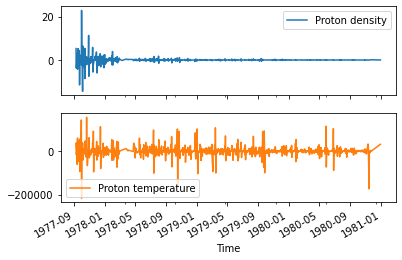

In [ ]:
lag_1 = data.diff().dropna()
print(data.head())
print(lag_1.head())
lag_1[["Proton density", "Proton temperature"]].plot(subplots=True)

<AxesSubplot:xlabel='Proton temperature', ylabel='Density'>

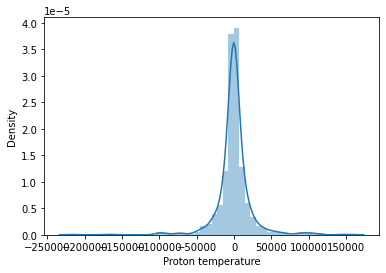

In [ ]:
sns.distplot(lag_1["Proton temperature"])

## Calculation autocorrelation

In [ ]:
autocorrelation = data["Proton temperature"].autocorr()
print("The autocorrelation of proton temperature is %4.2f" % (autocorrelation))

autocorrelation = data["Proton density"].autocorr()
print("The autocorrelation of proton density is %4.2f" % (autocorrelation))

The autocorrelation of proton temperature is 0.62
The autocorrelation of proton density is 0.86


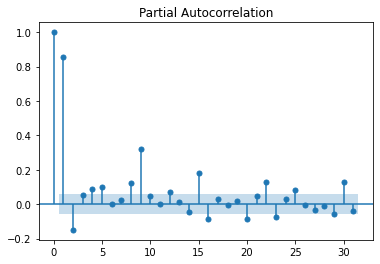

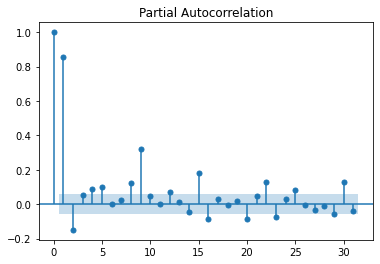

In [ ]:
plot_pacf(data["Proton density"].dropna())  # Don't know why it creates